In [1]:

from langchain_openai.embeddings import OpenAIEmbeddings
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, StateGraph
import unicodedata
from langchain_core.documents import Document
import pytesseract
from pdf2image import convert_from_path
import unicodedata
import re
from langchain_core.prompts import ChatPromptTemplate
from typing import TypedDict, List
from IPython.display import Image
from langchain_core.documents import Document
from langgraph.graph import START, END, StateGraph
from langchain_openai import OpenAIEmbeddings
from langchain_core.vectorstores import InMemoryVectorStore


In [31]:
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    model="gpt-4.1-2025-04-14",
    temperature=0,
    max_retries=2,
   
)

In [4]:
pdf_path = "HSC26-Bangla1st-Paper.pdf"
# Set Tesseract and Poppler paths
pytesseract.pytesseract.tesseract_cmd = r"C:/Program Files/Tesseract-OCR/tesseract.exe"
poppler_path = r"C:/poppler-24.08.0/Library/bin"

# Step 1: Convert PDF pages to images
images = convert_from_path("HSC26-Bangla1st-Paper.pdf", poppler_path=poppler_path)

# Step 2: Extract and clean text
def clean_text(text):
    text = unicodedata.normalize("NFC", text)
    text = re.sub(r"(পৃষ্ঠা|Page)\s*\d+", "", text)
    text = re.sub(r"\n+", "\n", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

docs = []
for i, img in enumerate(images):
    raw_text = pytesseract.image_to_string(img, lang="ben")
    cleaned = clean_text(raw_text)
    docs.append(Document(page_content=cleaned, metadata={"page": i+1}))


In [5]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=2000,
    chunk_overlap=30,
    add_start_index=True)

all_splits = text_splitter.split_documents(docs)

print(f"Split the pdf into {len(all_splits)} sub-documents.")

Split the pdf into 64 sub-documents.


In [6]:


# embedding model
embed_model = OpenAIEmbeddings(model="text-embedding-3-large")

# vector storage
vector_store = InMemoryVectorStore(embedding=embed_model)

# add document chunks to the vector store to get index chunks
document_ids = vector_store.add_documents(documents=all_splits)

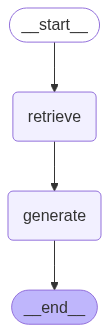

In [ ]:


prompt = ChatPromptTemplate.from_template("""
প্রশ্নটি খুব সংক্ষেপে (এক বা দুই শব্দে) উত্তর দাও।
শুধু তথ্যটি দাও, ব্যাখ্যা বা অনুচ্ছেদ দিও না।
Context (পাঠ্য):
{context}

প্রশ্ন:
{question}

উত্তর:
""")

class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

def retrieve(state: State):
    # print("Retrieving Information")
    question = state['question']
    retrieved_docs = vector_store.similarity_search(query=question,k=4)
    return {'context': retrieved_docs}

def generate(state: State):
    # print("Generating Response")
    docs_contents =  "\n\n".join([doc.page_content for doc in state["context"]])
    messages = prompt.invoke({'question': state['question'], 'context': state['context']})
    response = llm.invoke(messages)
    return {'answer': response}
        
builder = StateGraph(State)

builder.add_node("retrieve", retrieve)
builder.add_node("generate", generate)

builder.add_edge(START, "retrieve")
builder.add_edge("retrieve", "generate")
builder.add_edge("generate", END)
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

Image(graph.get_graph().draw_mermaid_png())

In [26]:
config = {"configurable": {"user_id": "1", "thread_id": "1"}}

# valiable to store the last answer
last_answer = ""

# Stream through the events
async for chunk in graph.astream(
    {'question': 'বিয়ের সময় কল্যাণীর প্রকৃত বয়স কত ছিল?'},
    stream_mode="updates",
    config=config
):
    if chunk.get('generate', {}).get('answer', ''):
        # Update the last_answer with the latest chunk
        last_answer = chunk['generate']['answer'].content.strip()

if last_answer:
    print(last_answer)


১৪ বছর


In [27]:
config = {"configurable": {"user_id": "1", "thread_id": "1"}}

# valiable to store the last answer
last_answer = ""

# Stream through the events
async for chunk in graph.astream(
    {'question': 'কাকে অনুপমের ভাগ্য দেবতা বলে উল্লেখ করা হয়েছে?'},
    stream_mode="updates",
    config=config
):
    if chunk.get('generate', {}).get('answer', ''):
        # Update the last_answer with the latest chunk
        last_answer = chunk['generate']['answer'].content.strip()

if last_answer:
    print(last_answer)


মামা


In [30]:
config = {"configurable": {"user_id": "1", "thread_id": "1"}}

# valiable to store the last answer
last_answer = ""

# Stream through the events
async for chunk in graph.astream(
    {'question': 'অনুপমের ভাষায় সুপুরুষ কাকে বলা হয়েছে?'},
    stream_mode="updates",
    config=config
):
    if chunk.get('generate', {}).get('answer', ''):
        # Update the last_answer with the latest chunk
        last_answer = chunk['generate']['answer'].content.strip()

if last_answer:
    print(last_answer)


বিনু
